In [43]:
# Simuluje jednoduchou obchodní strategii založenou na predikci: pokud model očekává růst, koupíme.
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
import pickle

sys.path.append(os.path.abspath("../scripts"))
from utils import Normalizer

In [44]:
# Načte připravené datasety
with open("../data/preprocessed_datasets.pkl", "rb") as f:
    vsechny_datasety = pickle.load(f)

# Definice modelu
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers,
                                  dropout=dropout, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [45]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

results = []

for data in vsechny_datasety:
    ticker = data['ticker']
    sector = data['sector']
    x_val = torch.tensor(data['x_val'], dtype=torch.float32)
    y_val = np.array(data['y_val'])
    norm = data['target_normalizer']

    model = LSTMModel(input_size=x_val.shape[2])
    model_path = f"../results/best_model_{ticker}.pth"
    if not os.path.exists(model_path):
        print(f"Model pro {ticker} chybí, přeskočeno")
        continue

    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    with torch.no_grad():
        preds = model(x_val).squeeze().numpy()

    pred_prices = norm.inverse_transform(preds.reshape(-1, 1)).flatten()
    true_prices = norm.inverse_transform(y_val.reshape(-1, 1)).flatten()

    if ticker in ["MSFT", "AAPL", "META"]:
        print(f"{ticker} - první predikce vs. skutečné:")
        print("Predicted:", pred_prices[:5])
        print("Actual:", true_prices[:5])

    profits = []
    for today, pred, tomorrow in zip(true_prices[:-1], pred_prices[:-1], true_prices[1:]):
        if pred > today:
            profits.append(tomorrow - today)
        else:
            profits.append(0)

    cumulative = np.cumsum(profits)
    avg_profit = np.mean(profits)

    results.append({
        "ticker": ticker,
        "sector": sector,
        "total_profit": cumulative[-1] if len(cumulative) > 0 else 0,
        "avg_profit": avg_profit
    })

MSFT - první predikce vs. skutečné:
Predicted: [322.83884 323.7119  324.58252 325.46484 325.98004]
Actual: [328.26950073 326.34173584 327.53793335 322.94104004 325.5607605 ]
AAPL - první predikce vs. skutečné:
Predicted: [178.5719  178.7931  178.86827 178.87408 178.67873]
Actual: [175.86106873 174.56060791 174.18338013 171.62216187 171.74124146]
META - první predikce vs. skutečné:
Predicted: [295.2427  296.6074  297.89594 298.83728 299.0173 ]
Actual: [322.48010254 315.48309326 311.34262085 307.20214844 312.53701782]


In [46]:
df = pd.DataFrame(results)
df = df.sort_values("total_profit", ascending=False)
df.head()

,ticker,sector,total_profit,avg_profit
8,GS,Finance,216.489990,0.603036
3,META,Communication,162.961029,0.453930
7,JPM,Finance,84.903870,0.236501
0,NVDA,Technology,63.127693,0.175843
17,UNP,Industrial,59.917236,0.166900


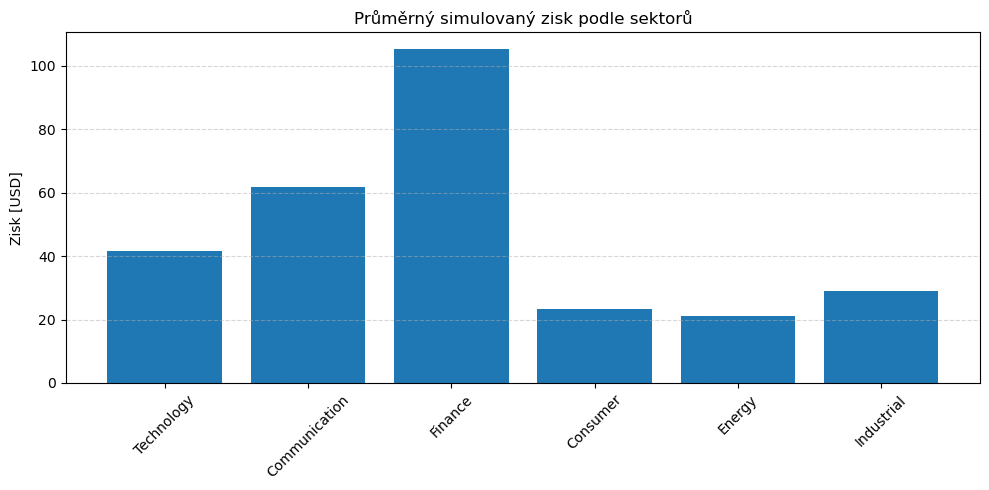

In [40]:
sector_summary = defaultdict(list)
for r in results:
    sector_summary[r["sector"]].append(r["total_profit"])

sector_avg = {s: np.mean(p) for s, p in sector_summary.items()}

plt.figure(figsize=(10,5))
plt.bar(sector_avg.keys(), sector_avg.values())
plt.title("Průměrný simulovaný zisk podle sektorů")
plt.ylabel("Zisk [USD]")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("../results/sector_profit_simulation.pdf")
plt.show()

In [47]:
df.to_csv("../results/profit_simulation_summary.csv", index=False)
print("Uloženo do profit_simulation_summary.csv")

Uloženo do profit_simulation_summary.csv
